# Generování textu pomocí znakového jazykového modelu

V notebooku si ukážeme, jak se pracuje s rekurentními sítěmi v knihovně PyTorch a použijeme je ke generování textu pomocí znakového jazykového modelu.

**Trénování jako klasifikace**

Trénování jazykového modelu formulujeme jako klasifikaci s učitelem. Každý znak každého řádku textu bude představovat jeden trénovací vzorek $(x, y)$, ve kterém
- vstupem $x$ je $t$-tý znak $s_t$ na aktuálním řádku
- a očekávaným výstupem $y$ (targetem) je následující znak $s_{t+1}$ na tomtéž řádku.

Pokud by např. celý náš datset bylo jediné slovo "ahoj", trénovací páry $(x, y)$ by mohly být tři: `('a', 'h')`, `('h', 'o')`, `('o', 'j')`.

**Sekvenční závislost**

Aby se model mohl naučil sekvenční závislosti, použijeme rekurentní síť se skrytým stavem $h$, který se bude během zpracovávání jednotlivých trénovacích párů aktualizovat a předávat dále. Sekvence více vzorků tedy nebudou tvořit paralelně zpracovatelné dávky vzájemně nezávislých párů $(x, y)$ jako např. obrázky a jejich třídy u CIFAR-10, u kterých nezáleží na pořadí. Zde každý znak $s_t$ považujeme za závislý na předchozích znacích $s_1, \ldots, s_{t-1}$ ze stejného řádku a odpovídající páry $(x, y)$ bude proto nutné zpracovávat "sériově" tak, jak po sobě znaky následují v textu. Skrytý stav se pak bude inicializovat vždy na začátku každé nové sekvence (řádku), jelikož jednolitvé řádky již považujeme za vzájemně nezávislé. Trénovací API modelu si proto navrhneme tak, aby jako vstup nepřijímal pouze jeden znak $s$, ale namísto toho
- sekvenci $\boldsymbol{s}_{:-1} = (s_1, \ldots, s_{T-1})$, tj. celý řádek textu kromě *posledního* znaku

a jako target byla
- sekvence $\boldsymbol{s}_{2:} = (s_2, \ldots, s_T)$, tj. celý řádek kromě *prvního* znaku.

Trénovacím párem $(\boldsymbol{x}, \boldsymbol{y})$ tak může být např. dvojice `('aho', 'hoj')`.

**Okrajové podmínky**

Abychom vyřešili okrajové podmínky, každému nadpisu na začátek i konec přidáme speciální START/STOP token. Abychom ho odlišili od ostatních znaků, zvolíme pro něj např. znak `'.'`.
- START/STOP token bude vždy prvním vstupem a jeho targetem bude první znak sekvence $s_1$. Rovněž při generování jako první vždy do sítě půjde START/STOP token a nebudeme tak muset jako uživatel určovat, kterým znakem má text začínat.
- START/STOP token bude také targetem pro poslední znak sekvence $s_T$. Token zajistí, že jako uživatel nebudeme při generování muset určovat, jak dlouhý má vymyšlený text být. Generovat budeme do chvíle, dokud predikovaným znakem nebude `'.'`.
- Token bychom mohli rozdělit na dva samostatné, tj. START a STOP, jak se obvykle uvádí. V takovém případě by ale START token jako první znak vstupu nikdy nemohl být targetem a výstupních tříd modelu by tak mělo být o jednu méně než počet znaků. Pro jednoduchost tedy ponecháme START a STOP tokeny spojené.

Trénovacím párem $(\boldsymbol{x}, \boldsymbol{y})$ tak nakonec po všech úpravách může být např. dvojice `('.ahoj', 'ahoj.')`, což odpovídá pěti vzorkům `('.', 'a')`, `('a', 'h')`, `('h', 'o')`, `('o', 'j')`, `('j', '.')`, mezi kterými se bude předávat skrytý stav.

In [1]:
import random
import time
from typing import Optional
import warnings

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import torch

In [2]:
sns.set()
torch.set_printoptions(threshold=400, edgeitems=4, profile='short')
warnings.simplefilter('ignore', category=numba.core.errors.NumbaPendingDeprecationWarning)

# Data

Data, která budeme generovat, jsou nadpisy článků z portálu novinky.cz nasbírané v letech 2014-2018. Všechny nadpisy jsou uloženy v jediném textovém souboru `headlines.txt` a to po jednotlivých řádcích. Pro jednoduchost z textu byla odstraněna interpunkce a diakritika. Jelikož celý text zabírá pouze cca 5 MB, načteme jej do paměti celý.

In [3]:
lines = open('../data/headlines.txt').readlines()
lines = [l.strip() for l in lines if l.strip()]  # remove empty lines
lines[:10]

['v anglii se pysni novymi prirustky ohrozeneho levharta snezneho',
 'afera s naklady na dopravu stala americkeho ministra zdravotnictvi kreslo',
 'soud potvrdil silnicnimu piratovi za zbesilou jizdu 8 5 roku vezeni',
 'ods s ano chteji skoncovat se zakazem prodeje o svatcich',
 'internet je samozrejmosti pro vetsinu domacnosti v cesku',
 'usa obratily uz netrvaji na sesazeni asada',
 'ridic vjel doprostred dejvickeho kulataku ze strechy auta ho policiste dostavali nasilim',
 'tesco celi vysetrovani kvuli problematickemu ucetnictvi',
 'babis okd lze resit odkoupenim dluhu nebo spolecnou firmou',
 'kytarista peter holmstrom hudba je vsude kolem']

Pro jednoduchost a lepší názornost ukázek a také snadnější ověření funkčnosti overfitem si ponecháme pouze 10 nejkratších nadpisů.

In [4]:
overfit_lines = sorted(lines, key=lambda l: len(l))
overfit_lines = overfit_lines[:10]
overfit_lines

['omluva',
 'puc v zimbabwe',
 'hudba jako lek',
 'smog na zlinsku',
 'jak na kocovinu',
 'zemrel b b king',
 'coetzee v praze',
 'prvni jarni den',
 'miluji te modre',
 'zeman je v cine']

# Embedding

Neuronové sítě, reurentní nevyjímaje, nejlépe pracují se vtupy jako vektory či matice reálných čísel. Proces převedení indexu nějakého tokenu (např. slova či znaku) na vektor se obvykle označuje jako tzv. embedding a v knihovně PyTorch ho obstarává modul `torch.nn.Embedding`. V principu modul provádí

$$
\boldsymbol{x} = \textrm{embedding}(i)
$$
kde
- $i \ge 0$ je přirozené číslo
- $\boldsymbol{x}$ je vektor o rozměru $D$, přičemž $D$ si určuje uživatel.

## Znaky jako čísla


Jako první krok tedy potřebujeme reprezentovat znaky jako čísla. Nejprve vytvoříme seznam všech unikátních znaků a to včetně dvou speciálního oddělovacího START/STOP tokenu.

In [5]:
delimiter = '.'
chars = [delimiter] + sorted(set(''.join(lines)))  # delimiter first
len(chars), ''.join(chars)

(38, '. 0123456789abcdefghijklmnopqrstuvwxyz')

Každému znaku přiřadíme číslo (index) a vytvořime si převodní slovník `chr2idx` mapující znak na jeho odpovídající index. Jelikož pro lepší efektivitu kódu textový preprocessing zkompilujeme pomocí knihovny Numba, použijeme speciální typovaný slovník `numba.typed.Dict`.

In [6]:
# chr2idx = {c: i for i, c in enumerate(chars)}  # won't work with numba.jit(nopython=True)
chr2idx = numba.typed.Dict()
for i, c in enumerate(chars):
    chr2idx[c] = i
chr2idx

DictType[unicode_type,int64]<iv=None>({.: 0,  : 1, 0: 2, 1: 3, 2: 4, 3: 5, 4: 6, 5: 7, 6: 8, 7: 9, 8: 10, 9: 11, a: 12, b: 13, c: 14, d: 15, e: 16, f: 17, g: 18, h: 19, i: 20, j: 21, k: 22, l: 23, m: 24, n: 25, o: 26, p: 27, q: 28, r: 29, s: 30, t: 31, u: 32, v: 33, w: 34, x: 35, y: 36, z: 37})

## Dávkové zpracování funkcí `lines2indices`

Vytvoříme si funkci `lines2indices`, která nám převede celou větu (nadpis) do sekvence indexů reprezentovanou jako `torch.Tensor`. Zároveň na začátek a konec sekvence přidá oddělovací START/STOP token. Jelikož budeme pro trénování sítě používat optimalizační metody založené na mini-dávkách, bude funkce jako vstupní argument přebírat `list` několika $N$ nadpisů a vrátí matici o rozměru $N \times T$, ve které $n$-tý řádek bude sekvence indexů pro $n$-tý nadpis v dávce.

Nadpisy samozřejmě nemusejí být stejně dlouhé a každá sekvence (vektor) indexů pak bude mít jiný rozměr. Matici proto vytvoříme tak velkou, aby pojala všechny sekvence celé a $T$ tedy bude rovno délce nejdelší sekvence v dávce. Sekvence kratší než $T$ doplníme o nastavenou hodnotu -1 (padding), kterou později budeme ignorovat.

Pro přlibližně dvojnásobné urychlení trénování funkci zkompilujeme pomocí knihovny Numba, k čemuž stačí ji pouze dekorovat zavoláním `@numba.jit`. Neývhodou knihovny Numba ovšem je, že nepodporuje tensory PyTorch, a tak budeme muset výsledek manuálně převést pomocí `torch.from_numpy`.

In [7]:
@numba.jit(nopython=True)
def lines2indices_numpy(lines, chr2idx, padding=-1):
    max_len = max([len(l) for l in lines])
    output = np.empty((len(lines), 2 + max_len), dtype=np.int64)  # (N, T)
    output.fill(padding)
    output[:, 0] = chr2idx[delimiter]  # START
    for i, line in enumerate(lines):
        for j in range(min(max_len, len(line))):
            output[i, j + 1] = chr2idx[line[j]]
        output[i, len(line) + 1] = chr2idx[delimiter]  # STOP
    return output

def lines2indices(lines: list[str], chr2idx: dict[str, int], padding: int = -1) -> torch.Tensor:
    return torch.from_numpy(lines2indices_numpy(lines, chr2idx, padding=padding))

In [8]:
# call this twice to remove the warnings
ids = lines2indices(overfit_lines, chr2idx)  # (N, T)
ids.shape, ids

(torch.Size([10, 17]),
 tensor([[ 0, 26, 24, 23, 32, 33, 12,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
         [ 0, 27, 32, 14,  1, 33,  1, 37, 20, 24, 13, 12, 13, 34, 16,  0, -1],
         [ 0, 19, 32, 15, 13, 12,  1, 21, 12, 22, 26,  1, 23, 16, 22,  0, -1],
         [ 0, 30, 24, 26, 18,  1, 25, 12,  1, 37, 23, 20, 25, 30, 22, 32,  0],
         [ 0, 21, 12, 22,  1, 25, 12,  1, 22, 26, 14, 26, 33, 20, 25, 32,  0],
         [ 0, 37, 16, 24, 29, 16, 23,  1, 13,  1, 13,  1, 22, 20, 25, 18,  0],
         [ 0, 14, 26, 16, 31, 37, 16, 16,  1, 33,  1, 27, 29, 12, 37, 16,  0],
         [ 0, 27, 29, 33, 25, 20,  1, 21, 12, 29, 25, 20,  1, 15, 16, 25,  0],
         [ 0, 24, 20, 23, 32, 21, 20,  1, 31, 16,  1, 24, 26, 15, 29, 16,  0],
         [ 0, 37, 16, 24, 12, 25,  1, 21, 16,  1, 33,  1, 14, 20, 25, 16,  0]]))

## One-hot embedding

Jak je uvedeno výše, modul `torch.nn.Embedding` je vrstva neuronové sítě, která jako vstup přijímá celé číslo (index) a vrací odpovídající embedding vektor. V praxi jsou vektory považovány za trénovatelný parametr a všechny uspořádany jako jediná váhová matice `weight` o tvaru `(num_tokens, embedding_size)`. Pokud je vstupem číslo `i: int`, modul `torch.nn.Embedding` pak nedělá nic jiného, než že vrátí `i`-tý řádek své matice `weight`, tj. `return weight[i]`. Parametr `i` může být libovolně rozměrný tensor, např. $N \times T$. Modul `torch.nn.Embedding` v takovém případě vrátí tensor vektorů pro každý z indexů tensoru `i` a výstup tak bude mít o jeden rozměr navíc, tj. např. $N \times T \times D$, kde $D$ je rozměr embedding vektoru (`embedding_size`).

Modul `torch.nn.Embedding` inicializuje vektory na náhodně hodnoty, protože předpokládá jejich optimalizaci. V našem jednoduchém případě s omezeným datasetem ovšem embeddingy trénovat nebudeme a ponecháme je jako konstanty. O něco lepších výsledků pak ale dosáhneme s one-hot vektory. Zadefinujeme si proto vlastní netrénovatelný embedding `OneHotEmbedding`, ve kterém váhy budou jednotková matice s rozměry $C \times C$ (shape `(num_tokens, num_tokens)`), kde $C$ je počet znaků.

In [9]:
class OneHotEmbedding(torch.nn.Module):

    def __init__(self, size: int) -> None:
        super().__init__()
        self.chars = chars
        self.register_buffer('weight', torch.eye(size))
    
    def forward(self, ids: torch.Tensor) -> torch.Tensor:
        shape = ids.shape  # e.g. (N, T)
        ids = ids.ravel()  # (N*T,)
        vectors = self.weight[ids]  # (N*T, D)
        return vectors.reshape(*shape, -1)  # (N, T, D)

In [10]:
embedding = OneHotEmbedding(len(chars))
inputs = embedding(ids.clamp(min=0))
batch_size, sequence_length, input_size = inputs.shape
batch_size, sequence_length, input_size  # (N, T, D)

(10, 17, 38)

# Rekurentní sítě v knihovně PyTorch

PyTorch implementuje tři nejčastěji používané typy rekurentních sítí: základní Reccurent Neural Network (RNN), Gated Recurrent Unit (GRU) a Long Short-Term Memory (LSTM). Základními a nejjednoduššími stavebními prvky jsou odpovídající vsrtvy `RNNCell`, `GRUCell` a `LSTMCell` v modulu `torch.nn`. Jejich API je téměr shodné.

Rekurentní "buňku" vytvoříme jako objekt, kterému předáme
- rozměr $D$ vstupních vektorů $\boldsymbol{x}_n$
- rozměr $H$ vektorů skrytých stavů $\boldsymbol{h}_{t,n}$.

Protože používáme one-hot embedding, bude v našem případě $D = C$ = `len(chars)`. $H$ si zvolíme např. 64.

In [11]:
hidden_size = 64
cell = torch.nn.RNNCell(len(chars), hidden_size)
cell

RNNCell(38, 64)

Dopředný průchod `RNNCell.forward` očekává
- vstup $\boldsymbol{x}$ (parametr `input`) jako vektor s rozměrem $D$
- a nepovinně také výchozí skrytý vektor $\boldsymbol{h}$ (parametr `hidden`) jako vektor s rozměrem $H$. Pokud parametr `hidden` není předán, je automaticky inicializován na nulový vektor.

Výstupem je nová hodnota skrytého stavu $\boldsymbol{h}'$, tj. opět vektor s rozměrem $H$.

Pošleme do buňky např. embeddingový vektor prvního znaku prvního nadpisu v datasetu:

In [12]:
inputs[0, 0]  # (D,)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [13]:
h1 = cell(inputs[0, 0])  # (H,)
h1.shape, h1

(torch.Size([64]),
 tensor([-0.15, -0.02, -0.15,  0.06,  0.13,  0.16, -0.05, -0.06,  0.03, -0.13,
          0.07,  0.08, -0.09,  0.09,  0.00, -0.03,  0.04, -0.06,  0.17, -0.25,
          0.19,  0.05, -0.07,  0.13, -0.12,  0.05, -0.04, -0.11,  0.00, -0.11,
         -0.01, -0.00, -0.04, -0.04,  0.01, -0.00, -0.19, -0.06, -0.25, -0.15,
         -0.02,  0.08,  0.10, -0.20, -0.06, -0.13,  0.03, -0.24,  0.00,  0.01,
         -0.03, -0.09, -0.13,  0.11, -0.01, -0.03,  0.11,  0.09,  0.01,  0.21,
          0.16,  0.06,  0.00, -0.03], grad_fn=<SqueezeBackward1>))

Proces můžeme zopakovat i pro druhý znak. Zároveň pošleme aktualizovaný skrytý stav z předchozího kroku.

In [14]:
h2 = cell(inputs[0, 1], h1)  # (H,)
h2

tensor([-1.91e-01, -1.33e-01, -3.64e-03, -5.77e-02,  2.62e-01,  1.04e-01,
         3.86e-02, -2.02e-01,  6.76e-03,  7.09e-02,  1.55e-01, -6.15e-02,
        -2.37e-02,  1.59e-01,  1.20e-01, -1.74e-01, -6.84e-02, -1.22e-01,
         3.15e-01, -2.77e-01,  2.41e-01, -6.45e-02, -8.94e-02,  1.37e-01,
        -8.47e-03,  5.49e-02, -6.30e-02, -2.23e-01, -1.32e-01,  5.39e-02,
         7.52e-02,  2.85e-01, -2.57e-01, -7.44e-02,  8.92e-02,  1.10e-01,
         8.19e-04, -1.79e-01, -1.73e-01,  2.97e-03, -1.10e-01,  1.08e-01,
         4.62e-02, -3.30e-01, -2.95e-01, -1.91e-01,  3.84e-02, -2.20e-01,
         3.91e-02,  3.21e-02, -3.28e-04, -6.86e-02, -8.70e-02, -1.39e-01,
         3.54e-01,  9.49e-02, -1.30e-01, -2.61e-02, -1.30e-02,  1.47e-01,
         2.52e-02,  6.77e-02, -5.35e-02, -9.28e-02],
       grad_fn=<SqueezeBackward1>)

Celou sekvenci včetně paddingu zpracujeme `for` cyklem:

In [15]:
h = torch.zeros(hidden_size)  # (H,)
for t in range(inputs.shape[1]):
    h = cell(inputs[0, t], h)
h.shape, h

(torch.Size([64]),
 tensor([-0.19, -0.01, -0.20, -0.08,  0.30,  0.24,  0.04, -0.10, -0.00, -0.13,
          0.21, -0.00,  0.10,  0.05,  0.05, -0.10, -0.10, -0.22,  0.29, -0.42,
          0.23, -0.02, -0.01,  0.15, -0.19,  0.09, -0.09, -0.21, -0.04, -0.00,
          0.09,  0.13, -0.09, -0.15,  0.19, -0.09, -0.12, -0.05, -0.16, -0.22,
          0.12, -0.01,  0.11, -0.27, -0.12, -0.23,  0.02, -0.23, -0.07, -0.03,
         -0.02, -0.17, -0.08, -0.03,  0.17, -0.03, -0.01,  0.21,  0.09,  0.25,
          0.16, -0.06, -0.14, -0.20], grad_fn=<SqueezeBackward1>))

Podobně jako ostatní moduly v knihovně PyTorch i `RNNCell` umožňuje také dávkové zpracování, tj. více sekvencí zároveň (paralelně). Do `RNNCell.forward` můžeme poslat vstup $\boldsymbol{x}$ i jako matici tvaru $N \times D$, kde každá sekvence představuje jeden řádek. Skrytý stav pak analogicky bude matice tvaru $N \times H$ (každá sekvence má svůj vlastní skrytý stav).

In [16]:
h = torch.zeros(batch_size, hidden_size)  # (N, H)
for t in range(sequence_length):
    h = cell(inputs[:, t], h)
h.shape, h

(torch.Size([10, 64]),
 tensor([[-0.19, -0.01, -0.20, -0.08,  ...,  0.16, -0.06, -0.14, -0.20],
         [-0.11, -0.04, -0.16, -0.07,  ...,  0.18, -0.05, -0.15, -0.14],
         [-0.13, -0.09, -0.14, -0.09,  ...,  0.17, -0.05, -0.11, -0.12],
         [-0.22, -0.10, -0.16, -0.08,  ...,  0.22, -0.04, -0.15, -0.12],
         ...,
         [-0.23, -0.11, -0.19,  0.07,  ...,  0.11,  0.02, -0.13, -0.18],
         [-0.25, -0.04, -0.14,  0.05,  ...,  0.18,  0.03, -0.07, -0.17],
         [-0.17, -0.06, -0.19,  0.04,  ...,  0.14,  0.01, -0.08, -0.23],
         [-0.22, -0.09, -0.13, -0.03,  ...,  0.10,  0.00, -0.06, -0.18]],
        grad_fn=<TanhBackward0>))

## Moduly `RNN`, `GRU` a `LSTM`

Celou sekvenci najednou (i dávku sekvencí) bez nutnosti manuálně implementovat cyklus `for` lze zpracovat pomocí tříd `RNN`, `GRU` a `LSTM`. Podobně jako u tříd `*Cell`, při vytváření předáme rozměr vstupního vektoru $D$ a rozměr srkytého vektoru $H$. V našem případě zadáme ještě `batch_first=True`, viz dále.

Abychom pro ilustraci dostali shodné výsledky jako u `RNNCell` výše, zkopíujeme navíc váhové matice a biasy z objektu `cell`.

In [17]:
rnn = torch.nn.RNN(len(chars), hidden_size, batch_first=True)
rnn.weight_hh_l0.data.copy_(cell.weight_hh)
rnn.weight_ih_l0.data.copy_(cell.weight_ih)
rnn.bias_hh_l0.data.copy_(cell.bias_hh)
rnn.bias_ih_l0.data.copy_(cell.bias_ih)
rnn

RNN(38, 64, batch_first=True)

Argument `batch_first=True` značí, že vstupy $\boldsymbol{x}$ má `RNN.forward` očekávat jako třírozměrné tensory tvaru $N \times T \times D$, tj. např. 10 sekvencí $\times$ délky $17$ $\times$ rozměr vstupu 39. To odpovídá naší proměnné `inputs` vytvořené výše. Výchozí hodnotou při vynechání argumentu je ovšem `batch_first=False`, kde vstupy jsou očekávány jako tensory tvaru $T \times N \times D$. Výhodou výchozího nastavení je, že každý okamžik $t$ posloupnosti je pak dávka tvaru $N \times D$, tj. `inputs[t].shape = (N, D)`.

Celou dávku sekvencí zpracujeme rekurentní sítí jediným zavoláním dopředného průchodu a na rozdíl od `RNNCell` tedy není nutný `for` cyklus.

In [18]:
outputs, hidden = rnn(inputs)
outputs.shape, hidden.shape, hidden

(torch.Size([10, 17, 64]),
 torch.Size([1, 10, 64]),
 tensor([[[-0.19, -0.01, -0.20, -0.08,  ...,  0.16, -0.06, -0.14, -0.20],
          [-0.11, -0.04, -0.16, -0.07,  ...,  0.18, -0.05, -0.15, -0.14],
          [-0.13, -0.09, -0.14, -0.09,  ...,  0.17, -0.05, -0.11, -0.12],
          [-0.22, -0.10, -0.16, -0.08,  ...,  0.22, -0.04, -0.15, -0.12],
          ...,
          [-0.23, -0.11, -0.19,  0.07,  ...,  0.11,  0.02, -0.13, -0.18],
          [-0.25, -0.04, -0.14,  0.05,  ...,  0.18,  0.03, -0.07, -0.17],
          [-0.17, -0.06, -0.19,  0.04,  ...,  0.14,  0.01, -0.08, -0.23],
          [-0.22, -0.09, -0.13, -0.03,  ...,  0.10,  0.00, -0.06, -0.18]]],
        grad_fn=<StackBackward0>))

Můžeme si všimnout, že vrstva na rozdíl od `RNNCell` vrátila dvojici výstupů:
- `outputs` je tensor tvaru $N \times T \times H$, viz dále,
- `hidden` je výsledný skrytý stav pro každou sekvenci v dávce po zpracování sekvence jako tensor tvaru $1 \times N \times H$, viz dále.

Tensor `outputs` obsahuje
- pro každou z $N$ paralelně zpracovávaných sekvencí
  - pro každý z $T$ vstupů sekvence (např. pro všechny znaky nadpisu)
    - vektor skrytého stavu *poslední vrstvy* RNN o rozměru $H$.

Jelikož v našem případě je RNN jednovrstvá, obsahuje `outputs` historii skrytých stavů RNN tak, jak se vyvíjely během zpracovávání sekvence. Poslední výstup `outputs[:, -1, :]` je roven poslednímu skrytému stavu.

Tensor `hidden` obsahuje stavové vektory po zpracování posledního okamžiku v posloupnosti $t = T$, tj. po dokončení sekvence. První ze tří rozměrů má velikost 1, protože používáme jednosměrnou rekurentní síť. V případě obousměrně rekurence (`bidirectional=True`) bychom dostali `hidden` tvaru $2 \times N \times H$, tj. každý z obou směrů zpracování by si držel svůj vlastní skrytý stav.

In [19]:
# same as hidden in our case
outputs[:, -1, :].shape, outputs[:, -1, :]  # (N, H)

(torch.Size([10, 64]),
 tensor([[-0.19, -0.01, -0.20, -0.08,  ...,  0.16, -0.06, -0.14, -0.20],
         [-0.11, -0.04, -0.16, -0.07,  ...,  0.18, -0.05, -0.15, -0.14],
         [-0.13, -0.09, -0.14, -0.09,  ...,  0.17, -0.05, -0.11, -0.12],
         [-0.22, -0.10, -0.16, -0.08,  ...,  0.22, -0.04, -0.15, -0.12],
         ...,
         [-0.23, -0.11, -0.19,  0.07,  ...,  0.11,  0.02, -0.13, -0.18],
         [-0.25, -0.04, -0.14,  0.05,  ...,  0.18,  0.03, -0.07, -0.17],
         [-0.17, -0.06, -0.19,  0.04,  ...,  0.14,  0.01, -0.08, -0.23],
         [-0.22, -0.09, -0.13, -0.03,  ...,  0.10,  0.00, -0.06, -0.18]],
        grad_fn=<SliceBackward0>))

Rekurentní síť `RNN` můžeme vytvořit i např. dvouvrstvou zadáním `num_layers=2` při vytváření objektu. Výstup první vrstvy je předán jako vstup do druhé vrstvy, která má vlastní parametry a skryté stavy se stejnými rozměry. Výstup `outputs` z dopředného průchodu potom obsahuje historii skrytých stavů pouze z druhé (poslední) vrstvy. Finální skryté stavy `hidden` naopak dostaneme pro všechny (obě) vrstvy, ale pouze pro poslední prvek sekvence a to jako tensor tvaru $1 \times N \times 2H$.

Zřejmě nejlépe celé API shrnuje následující diagram, kde skryté stavy jsou reprezentovány jako dvojice $h_n, c_n$, protože obrázek popisuje síť typu LSTM.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

# Predikce znaků a loss

Na vektory skrytých stavů $\boldsymbol{h}_t$ budeme pohlížet jako na příznaky a predikovat z nich skóre (logity) $\boldsymbol{z}_t$ pro následující znak $s_{t+1}$. Použijeme jednoduchý lineární klasifikátor formy
$$
\boldsymbol{z}_t = \boldsymbol{h}_t \cdot \boldsymbol{w} + \boldsymbol{b}
$$
kde
- $\boldsymbol{w}$ je váhová matice o rozměrech $H \times C$, kde $C$ je počet možných znaků,
- $\boldsymbol{b}$ je vektor biasů o rozměru $C$
- $\boldsymbol{z}_t$ je vektor logitů s rozměrem $C$.

In [20]:
classifier = torch.nn.Linear(hidden_size, len(chars))
classifier

Linear(in_features=64, out_features=38, bias=True)

Do klasifikátoru pošleme sekvenci $\boldsymbol{z}_{:-1}$, tj. všechny znaky vstupní sekvence kromě posledního, protože predikce, jaký znak by měl následovat za posledním START/STOP tokenem `'.'`, už nás nezajímá.

In [21]:
logits = outputs[:, :-1, :]  # (N, T-1, H)
logits = logits.reshape(-1, hidden_size)  # (N*(T-1), H)
logits = classifier(logits)  # (N*(T-1), C)
logits.shape, logits

(torch.Size([160, 38]),
 tensor([[-0.03, -0.03, -0.05, -0.02,  ...,  0.08, -0.01, -0.04,  0.17],
         [-0.02, -0.01, -0.04, -0.08,  ...,  0.07, -0.07, -0.06,  0.11],
         [-0.03,  0.05, -0.07, -0.08,  ...,  0.16, -0.05, -0.01,  0.12],
         [ 0.03, -0.03, -0.03, -0.01,  ..., -0.01, -0.06, -0.06,  0.09],
         ...,
         [-0.07,  0.00, -0.07, -0.03,  ...,  0.01,  0.00, -0.03,  0.10],
         [ 0.02, -0.02, -0.07, -0.04,  ...,  0.03, -0.05, -0.07,  0.01],
         [ 0.02, -0.00,  0.01,  0.00,  ...,  0.10, -0.05, -0.09,  0.09],
         [-0.04, -0.08,  0.01,  0.01,  ...,  0.15,  0.04, -0.00,  0.15]],
        grad_fn=<AddmmBackward0>))

Požadovanými predikcemi neboli "targety" je vektor indexů znaků (klasifikačních tříd) vstupní sekvence posunutý o jednu pozici doleva, čímž odpadne první znak. Se zohledněním dávkového zpracování tedy targety budou všechny sloupce matice `ids` kromě prvního, které následně rozvineme do vektoru o délce $N \cdot (T-1)$

In [22]:
targets = ids[:, 1:]  # (N, T-1)
targets = targets.ravel()  # (N*(T-1))
targets.shape, targets

(torch.Size([160]),
 tensor([26, 24, 23, 32, 33, 12,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 27, 32,
         14,  1, 33,  1, 37, 20, 24, 13, 12, 13, 34, 16,  0, -1, 19, 32, 15, 13,
         12,  1, 21, 12, 22, 26,  1, 23, 16, 22,  0, -1, 30, 24, 26, 18,  1, 25,
         12,  1, 37, 23, 20, 25, 30, 22, 32,  0, 21, 12, 22,  1, 25, 12,  1, 22,
         26, 14, 26, 33, 20, 25, 32,  0, 37, 16, 24, 29, 16, 23,  1, 13,  1, 13,
          1, 22, 20, 25, 18,  0, 14, 26, 16, 31, 37, 16, 16,  1, 33,  1, 27, 29,
         12, 37, 16,  0, 27, 29, 33, 25, 20,  1, 21, 12, 29, 25, 20,  1, 15, 16,
         25,  0, 24, 20, 23, 32, 21, 20,  1, 31, 16,  1, 24, 26, 15, 29, 16,  0,
         37, 16, 24, 12, 25,  1, 21, 16,  1, 33,  1, 14, 20, 25, 16,  0]))

Z důvodu různých délek sekvencí v dávce jsme matici `ids` nastavili o hodnoty -1. Predikce po skončení sekvence nás již ovšem nezajímají a neměli bychom je při trénování zohledňovat v kritériu. Třída `torch.nn.CrossEntropyLoss` s tímto scénářem počítá a umožňuje nastavit parametr `ignore_index`. Všechny vzorky, jejichž target hodnota je rovna `ignore_index` pak nebudou při vyhodnocení lossu zohledněny.

In [23]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
criterion

CrossEntropyLoss()

In [24]:
loss = criterion(logits, targets)
loss.item()

3.6450929641723633

Predikce pro znaky za koncem sekvence, jejichž targety jsou -1, můžeme ignorovat také manuálním filtrováním relevantních řádků.

In [25]:
mask = targets >= 0  # (N*(T-1),)
mask

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

Kritérium pak můžeme vytvořit bez `ignore_index`.

In [26]:
criterion = torch.nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

Z `logits` i `targets` vybereme pouze relevantní řádky a dostaneme shodnou hodnotu lossu jako s použitím `ignore_index`.

In [27]:
loss = criterion(logits[mask], targets[mask])
loss.item()

3.645092487335205

# Model jako třída `torch.nn.Module`

Celý dosavadní postup si pro přehlednost refaktorujeme do jediného modulu. Třídu nazveme `CharRNN` a bude obsahovat
- `OneHotEmbedding` embedding vrstvu,
- rekurentní modul `RNN`, `GRU` nebo `LSTM`,
- a klasifikátor typu `Sequential`.

Modul `CharRNN` navíc navrhneme konfigurovatelný tak, aby šlo jednoduše typ rekurentní modulu a jeho počet vrstev a také počet a velikosti vrstev klasifkátoru jako vícevrstvého perceptronu. V dopředném průchodu model bude očekávat
- dávku indexů `ids` jako matici o rozměrech $N \times T$
- a nepovinně také výchozí skryté stavy `hidden` pro každou z $N$ sekvencí v dávce jako tensor s rozměry $1 \times N \times H$,

a vrátí
- skóre (logity) přes všechny třídy (znaky) pro každý znak v sekvenci jako matici s rozměry $N \times T \times C$
- a poslední skryté stavy pro každou sekvenci v dávce jako tensor s rozměry $1 \times N \times H$.

In [28]:
class CharRNN(torch.nn.Module):

    def __init__(
            self,
            num_chars: int,
            hidden_size: int = 64,
            num_layers: int = 1,
            rnn_type: type[torch.nn.Module] = torch.nn.RNN,
            mlp_config: tuple[int, ...] = tuple()
    ) -> None:
        super().__init__()

        self.embedding = OneHotEmbedding(num_chars)
        self.rnn = rnn_type(num_chars, hidden_size, num_layers=num_layers, batch_first=True)
        self.classifier = torch.nn.Sequential()
        input_size = hidden_size
        for layer_size in mlp_config:
            self.classifier.append(torch.nn.Linear(input_size, layer_size))
            self.classifier.append(torch.nn.ReLU())
            input_size = layer_size
        self.classifier.append(torch.nn.Linear(input_size, num_chars))
    
    def forward(self, ids: torch.Tensor, hidden: Optional[torch.Tensor] = None) -> tuple[torch.Tensor, ...]:
        inputs = self.embedding(ids)  # (N, T, D)
        outputs, hidden = self.rnn(inputs, hidden)  # (N, T, H), (1, N, H)
        logits = self.classifier(outputs)  # (N, T, C)
        return logits, hidden

In [29]:
model = CharRNN(len(chars))
model

CharRNN(
  (embedding): OneHotEmbedding()
  (rnn): RNN(38, 64, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=38, bias=True)
  )
)

Stejně jako výše do modelu pošleme indexy znaků vyjma posledního START/STOP tokenu. Dostaneme zpět predikce `logits` a poslední skryté stavy `hidden`. Hodnoty se budou od výstpů výše lišit, protože moduly uvnitř `CharRNN` byly náhodně inicializovány.

In [30]:
logits, hidden = model(ids[:, :-1])  # (N*(T-1), C), (1, N, H)
logits.shape, logits

(torch.Size([10, 16, 38]),
 tensor([[[ 2.14e-02, -1.63e-02, -1.05e-01, -5.54e-02,  ...,  2.02e-01,
           -1.78e-01,  1.59e-01,  7.91e-02],
          [-8.42e-02, -1.42e-02, -1.52e-01, -3.49e-02,  ...,  1.89e-01,
           -2.86e-01,  1.58e-01,  4.21e-02],
          [-4.69e-02, -1.66e-01, -1.42e-01, -9.29e-02,  ...,  4.29e-02,
           -1.36e-01,  1.07e-01,  1.21e-01],
          [ 1.23e-03, -1.23e-01, -2.01e-01, -4.41e-03,  ...,  8.97e-02,
           -1.38e-01,  1.77e-01,  7.41e-02],
          ...,
          [-3.15e-02,  1.38e-02, -1.37e-01, -2.77e-02,  ...,  2.27e-01,
           -2.78e-01,  7.02e-02,  1.25e-01],
          [-2.05e-02,  1.27e-02, -1.32e-01, -2.55e-02,  ...,  2.31e-01,
           -2.77e-01,  6.62e-02,  1.18e-01],
          [-2.59e-02,  1.15e-02, -1.37e-01, -2.68e-02,  ...,  2.28e-01,
           -2.75e-01,  6.90e-02,  1.23e-01],
          [-2.30e-02,  1.21e-02, -1.36e-01, -2.58e-02,  ...,  2.28e-01,
           -2.75e-01,  6.73e-02,  1.18e-01]],
 
         [[ 2.14e-0

Opět manuálně vymaskujeme predikce pro nastavené hodnoty za konci sevkencí:

In [31]:
mask = targets >= 0  # (N*(T-1),)
mask.shape, mask

(torch.Size([160]),
 tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
         False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True, False,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  T

Pro jednoduché maskování řádků potřebujeme nejprve `logits` přetvarovat do matice tvaru $(N \cdot (T-1)) \times C$. Poté vyhodnotíme maskovaný loss, tj. bez nastavených hodnot.

In [32]:
loss = criterion(logits.reshape(-1, logits.shape[-1])[mask], targets[mask])
loss.item()

3.6509182453155518

# Zpětný průchod

Trénovat budeme pomocí minidávkových gradientních metod a to víceméně shodným způsobem jako klasifikátor pro obráky z datasetu CIFAR-10. Pro ukázku zvolíme např. nejjednodušší stochastic gradient descent `torch.optim.SGD`.

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

 Pro jednu dávku představují zpětný průchod a jeden krok metody největšího spádu tři následující kroky:

In [34]:
optimizer.zero_grad()
loss.backward()
optimizer.step()

Můžeme si ověřit, zda např. jedna váhových matic rekurentního modulu obrdžel ze zpětné propagace gradient.

In [35]:
model.rnn.weight_hh_l0.grad

tensor([[ 2.04e-03,  6.79e-04, -1.03e-03,  1.04e-03,  ...,  1.78e-04,
          6.04e-04, -5.11e-04,  3.24e-03],
        [-1.10e-03, -3.44e-04,  1.85e-04, -1.85e-04,  ...,  8.19e-04,
         -1.50e-04, -3.69e-04, -1.46e-03],
        [ 1.85e-03,  3.97e-04,  2.48e-04,  6.09e-04,  ...,  6.44e-04,
          1.21e-03, -7.77e-04,  4.29e-03],
        [ 5.45e-04,  3.61e-04, -4.64e-04,  1.79e-04,  ...,  4.64e-04,
         -1.20e-03, -9.08e-05,  3.89e-04],
        ...,
        [ 4.34e-03, -1.14e-04,  7.66e-05,  1.02e-03,  ..., -1.09e-03,
          1.48e-03, -1.34e-03,  5.69e-03],
        [-1.65e-03,  5.15e-04, -5.83e-05, -4.77e-04,  ...,  4.44e-04,
         -3.38e-04,  6.19e-04, -2.04e-03],
        [-1.68e-03,  4.44e-04, -3.98e-04, -7.69e-04,  ...,  7.45e-04,
         -6.25e-04,  1.09e-03, -3.28e-03],
        [-4.36e-03, -6.30e-04,  4.68e-04, -1.44e-03,  ..., -1.52e-04,
         -1.42e-03,  7.43e-04, -4.49e-03]])

# Generování textu

Pokud máme natrénovaný model, můžeme zkusit z něj vygenerovat text. Model v dopředném průchodu očekává indexy `ids` a vrátí predikce následujících znaků. Jelikož by každá sekvence sekvence měla začínat oddělovacím START/STOP tokenem, vytvoříme si dávku indexů znaku `delimiter` jako matici o tvaru $N \times 1$, tedy vlastně sloupcový vektor.

In [36]:
gen_ids = torch.empty((batch_size, 1), dtype=torch.int64).fill_(chr2idx[delimiter])  # (N, 1)
gen_ids

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

Dávku indexů `gen_ids` pošleme do modelu a dostaneme zpět skóre (logity), které znaky by měly podle sítě následovat. Protože pro všechny sekvence v dávce byly inicializace i vstup shodné, dostaneme shodné i vektory logitů.

In [37]:
gen_logits, gen_hidden = model(gen_ids)  # (N, 1, C), (1, N, H)
gen_logits.shape, gen_logits

(torch.Size([10, 1, 38]),
 tensor([[[ 0.02, -0.01, -0.11, -0.06, -0.09,  0.17,  0.08,  0.05,  0.01, -0.16,
           -0.13, -0.17,  0.08,  0.16,  0.00,  0.16, -0.18, -0.08,  0.03,  0.13,
            0.03, -0.28,  0.05, -0.02,  0.00,  0.05, -0.01, -0.15,  0.01,  0.10,
           -0.08, -0.08, -0.08, -0.01,  0.20, -0.18,  0.16,  0.08]],
 
         [[ 0.02, -0.01, -0.11, -0.06, -0.09,  0.17,  0.08,  0.05,  0.01, -0.16,
           -0.13, -0.17,  0.08,  0.16,  0.00,  0.16, -0.18, -0.08,  0.03,  0.13,
            0.03, -0.28,  0.05, -0.02,  0.00,  0.05, -0.01, -0.15,  0.01,  0.10,
           -0.08, -0.08, -0.08, -0.01,  0.20, -0.18,  0.16,  0.08]],
 
         [[ 0.02, -0.01, -0.11, -0.06, -0.09,  0.17,  0.08,  0.05,  0.01, -0.16,
           -0.13, -0.17,  0.08,  0.16,  0.00,  0.16, -0.18, -0.08,  0.03,  0.13,
            0.03, -0.28,  0.05, -0.02,  0.00,  0.05, -0.01, -0.15,  0.01,  0.10,
           -0.08, -0.08, -0.08, -0.01,  0.20, -0.18,  0.16,  0.08]],
 
         [[ 0.02, -0.01, -0.11, 

Znak, který by podle sítě měl za START/STOP tokenem následovat je ten, jehož skóre vyšlo nejvyšší. Mohli bychom tedy použít např. metodu `argmax` a to přes poslední dimenzi logitů:

In [38]:
gen_preds = gen_logits.argmax(dim=-1)  # (N*1,)
gen_preds

tensor([[34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34],
        [34]])

Zde ovšem problémem je, že se model chová deterministicky a při stejných vstupech bude generovat vždy stené výstupy. Pokud tedy budeme generování inicializovat pouze START/STOP tokenem, ve všech sekvencích dostaneme shodné predikce následujících znaků a tedy i shodný výsledný text. Tomuto chování se můžeme vyhnout dvěma způsoby:
1. Mohli bychom manuálně inicializovat každou sekvenci více znaky než pouze START/STOP tokenem. Jako inicializaci bychom tedy použili matici $N \times 2$, ve které by první sloupec obsahoval indexy oddělovacího tokenu a druhý sloupec náhodné indexy vybrané např. pomocí `torch.randint`. Pokud bychom chtěli zohlednit statistiku jazyka, museli bychom vybírat např. dle pravděpodobnosti výskytu znaku či jinak. Další generování by ovšem stále bylo deterministické, a tak např. inicializace sekvencí `'.a'` by stejně vždy vedla na sekvenci `'.ahoj.'`.
2. Pokaždé trochu jiný výsledek zajistíme nedeterministickým výběrem následujícího znaku z predikovaných skóre. Následující znak vybereme náhodně, zohledníme přitom ale predikovaná skóre. Částečně náhodný "cinknutý" výběr dle pravděpodobností umí např. funkce `torch.multinomial`, která jako vstup požaduje pravděpodobnostní rozdělení přes jednotlivé třídy a po zavolání vrátí index náhodně vybrané třídy při zohlednění pravděpodobností. Jako parametr je ještě nutné zadat počet indexů, které má funkce vygenerovat, a tvar tensoru jejich uspořádání.

Použijeme druhý způsob, protože je jednodušší, elegantnější a nevyžaduje po uživateli vlastnoruční počítání statistik jazyka.

Funkce `torch.multinomial` se používá následovně. Např. 20 hodů neférovou kostkou, u které šestka padá s pravděpodobností 50 %, bychom mohli simulovat takto:

In [39]:
1 + torch.multinomial(torch.tensor([0.1, 0.1, 0.1, 0.1, 0.1, 0.5]), 20, replacement=True)

tensor([6, 6, 4, 6, 6, 6, 6, 3, 6, 5, 6, 6, 6, 6, 6, 6, 3, 6, 6, 6])

My funkci `torch.multinomial` použijeme pro výběr následujícího znaku. Z modelem predikovaných skóre *z posledního kroku* nejprve vyrobíme pravděpodobnostní rozdělení pomocí softmaxu.

In [40]:
gen_probs = gen_logits[:, -1, :].softmax(dim=1)  # (N, C)
gen_probs.shape, gen_probs

(torch.Size([10, 38]),
 tensor([[0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
          0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03,
          0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.02,
          0.03, 0.03],
         [0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
          0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03,
          0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.02,
          0.03, 0.03],
         [0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
          0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03,
          0.03, 0.03, 0.03, 0.02, 0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.02,
          0.03, 0.03],
         [0.03, 0.03, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02,
          0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.03, 0.03, 0.03, 0.02, 0.03, 0.03,
      

Poté následující znak vybereme funkcí `torch.multinomial`. Pokud je vstupem dávka pravděpodobnostních rozdělení, funkce výběr provede pro každý řádek vstupu. Jelikož vybíráme pouze jeden znak, nepotřebujeme zadávat `replacement=True`.

In [41]:
gen_preds = torch.multinomial(gen_probs, 1)  # (N, 1)
gen_preds

tensor([[13],
        [21],
        [18],
        [23],
        [13],
        [ 8],
        [34],
        [36],
        [10],
        [35]])

Nakonec sloupcový vektor predikcí připojíme ke stávajícím indexům:

In [42]:
gen_ids = torch.cat((gen_ids, gen_preds), dim=1)  # (N, 2)
gen_ids

tensor([[ 0, 13],
        [ 0, 21],
        [ 0, 18],
        [ 0, 23],
        [ 0, 13],
        [ 0,  8],
        [ 0, 34],
        [ 0, 36],
        [ 0, 10],
        [ 0, 35]])

Nyní máme dvě možnosti, jak pokračovat v generování textu.
1. Buď vezmeme predikce `gen_preds` a skryté stavy `hidden` a pošleme je do modelu pro vygenerování nových vektorů logitů, tj. síť provede pouze jeden nový krok,
2. nebo vezmeme celé aktuální sekvence `gen_ids`, skryté stavy `hidden` zahodíme a necháme model zpracovat opětovně celé sekvence od začátku.

Byť efektivnější a intuitivnější variantou je první možnost, zvolíme druhou, protože umožňuje jednodušší práci s modelem především při inicializaci skrytých stavů. Generování navíc není výpočetně kritická část kódu, takže to na efektivitu nebude mít téměř žádný vliv.

In [43]:
gen_logits, gen_hidden = model(gen_ids)  # (N, 2, C), (1, N, H)
gen_probs = gen_logits[:, -1, :].softmax(dim=-1)  # (N, C)
gen_preds = torch.multinomial(gen_probs, 1)  # (N, 1)
gen_ids = torch.cat((gen_ids, gen_preds), dim=1)  # (N, 3)
gen_ids

tensor([[ 0, 13, 28],
        [ 0, 21, 22],
        [ 0, 18, 26],
        [ 0, 23, 25],
        [ 0, 13,  6],
        [ 0,  8,  3],
        [ 0, 34, 32],
        [ 0, 36, 36],
        [ 0, 10, 11],
        [ 0, 35, 12]])

Postup bychom mohli opakovat např. 100x.

Vygenerované indexy převedeme do textové pomocí funkce `indices2lines` definované níže. Funkce převezme matici indexů a vrátí seznam řádků jako `list[str]`. Převod index na znak je přitom jednoduché indexování seznamu znaků `chars`. Znaky jsou poté spojeny do řetězce a z každého řádku je zahozeno vše od prvního nalezeného START/STOP tokenu dále.

In [44]:
def indices2lines(ids: torch.Tensor) -> list[str]:
    batch_size, sequence_length = ids.shape
    lines = [
        ''.join(chars[ids[i, j]] for j in range(sequence_length))
        for i in range(batch_size)
    ]
    lines = [l.strip(delimiter).split(delimiter, 1)[0] for l in lines]
    return lines

Model v tuto chvíli není natrénovaný a vygenerovaný text tak samozřejmě nebude dávat smysl.

In [45]:
indices2lines(gen_ids)

['bq', 'jk', 'go', 'ln', 'b4', '61', 'wu', 'yy', '89', 'xa']



Abychom zbytečně neopakovali kód, generování textu postupem výše si zadefinujeme jako funkci `generate`, která převezme
- znakový jazykový model `model`,
- seznam inicializačních textů `init_texts`, které budou doplněny o vygenerovaný text,
- maximální délku vygenerovaného textu `max_length`,
- přepínač `deterministic` určující, zda má či nemá být výběr dalšího znaku deterministický,

a vrátí seznam řádků jako `list[str]`.

In [46]:
def generate(model: CharRNN, init_texts: list[str], max_length: int = 100, deterministic: bool = False) -> list[str]:
    device = next(model.parameters()).device
    ids = lines2indices(init_texts, chr2idx).to(device=device)  # (N, T)
    ids = ids[:, :-1]  # 
    for t in range(max_length - ids.shape[1]):
        logits, hidden = model(ids)  # (N, T, C), (1, N, H)
        logits = logits[:, -1, :]  # (N, C)
        if deterministic:
            preds = logits.argmax(dim=1)  # (N,)
        else:
            preds = torch.multinomial(logits.softmax(dim=1), 1)  # (N,)
        ids = torch.cat((ids, preds.reshape(-1, 1)), dim=1)  # (N, T+1)
    return indices2lines(ids)

In [47]:
generate(model, ['s'] * 10)

['s35i7ubhqaz1hvqsrrzso 9rw5wnm 150vubw4xizhvqwq hai',
 's',
 'sit3bf4hgocg0jwvnapeeedc0hc ibdqmtpl8ow0wdbe0',
 'sra80g k86 nu0i43',
 'sewb59mimg2ec2bcm27ewd3 hn 43',
 'sc5xzd',
 'ssdp4h',
 's574ucamasbmnwln7q81zz3x9 neirkdy',
 'sar10plsxrzsegtmbwg3u0qyxqxqnu4edgu2co',
 'su']

# Trénování

Kód pro trénování a validaci zabalíme do funkcí `train` a `validate`. Obě provedou jeden průchod daty, tj. jednu epochu, a vrátí průměrné hodnoty lossu a přesnosti predikce (accuracy). Rozdíl mezi oběma funkcemi je pouze ve zpětném průchodu, který probíhá pouze při trénování.

In [48]:
def train(
        loader: torch.utils.data.DataLoader,
        model: CharRNN,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        batch_size: int = 1,
        ignore_index: int = -1
) -> tuple[float, float]:
    model.train()
    device = next(model.parameters()).device
    train_loss, train_acc = 0., 0.
    for lines in loader:
        # prepare data
        ids = lines2indices(lines, chr2idx)  # (N, T)
        inputs = ids[:, :-1].to(device=device)  # (N, T-1)
        targets = ids[:, 1:].ravel().to(device=device)  # (N*(T-1),)
        
        # forward pass
        logits, hidden = model(inputs)  # (N, T-1, C), (1, N, H)
        
        # mask padded indices
        mask = targets != ignore_index  # (N*(T-1),)
        logits = logits.reshape(-1, logits.shape[-1])  # (N*(T-1), C)
        logits = logits[mask]  # (N*sum(mask), C)
        targets = targets[mask]  # (N*sum(mask),)

        # calcualte metrics
        loss = criterion(logits, targets)  # ()
        acc = (logits.argmax(dim=1) == targets).float().mean()  # ()

        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate
        train_loss += loss.item()
        train_acc += acc.item()

    train_loss /= len(loader)
    train_acc /= len(loader)
    return train_loss, train_acc

In [49]:
def validate(
        loader: torch.utils.data.DataLoader,
        model: CharRNN,
        criterion: torch.nn.Module,
        batch_size: int = 1,
        ignore_index: int = -1
) -> tuple[float, float]:
    model.eval()
    device = next(model.parameters()).device
    val_loss, val_acc = 0., 0.
    for lines in loader:
        # prepare data
        ids = lines2indices(lines, chr2idx)  # (N, T)
        inputs = ids[:, :-1].to(device=device)  # (N, T-1)
        targets = ids[:, 1:].ravel().to(device=device)  # (N*(T-1),)
        
        # forward pass
        logits, hidden = model(inputs)  # (N, T-1, C), (1, N, H)
        
        # mask padded indices
        mask = targets != ignore_index  # (N*(T-1),)
        logits = logits.reshape(-1, logits.shape[-1])  # (N*(T-1), C)
        logits = logits[mask]  # (N*sum(mask), C)
        targets = targets[mask]  # (N*sum(mask),)

        # calcualte metrics
        loss = criterion(logits, targets)  # ()
        acc = (logits.argmax(dim=1) == targets).float().mean()  # ()

        # accumulate
        val_loss += loss.item()
        val_acc += acc.item()

    val_loss /= len(loader)
    val_acc /= len(loader)
    return val_loss, val_acc

## Overfit

Nyní jsou všechny komponenty pro trénování připravené a můžeme spustit trénování. Pro začátek je lepší vyzkoušet nejprve několik málo řádků `overfit_lines` a teprve poté spustit trénování na plných datech.

In [50]:
# reproducibility
random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# hyperparameters
num_epochs = 100
batch_size = 10  # N
hidden_size = 512  # H
num_layers = 1  # L
rnn_type = torch.nn.GRU
mlp_config = ()
learning_rate = 1e-2
device = 'cuda'  # set to 'cpu' if CUDA not available

# overfit data
train_lines = overfit_lines
val_lines = overfit_lines
print(f"train:val split = {len(train_lines)}:{len(val_lines)}")

# model
model = CharRNN(len(chars), hidden_size=hidden_size, num_layers=num_layers, rnn_type=rnn_type, mlp_config=mlp_config)
model.to(device=device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loaders
train_loader = torch.utils.data.DataLoader(train_lines, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_lines, batch_size=batch_size, shuffle=False)

# sanity check: validate before training
train_loss, train_acc = validate(train_loader, model, criterion, batch_size=batch_size)
val_loss, val_acc = validate(val_loader, model, criterion, batch_size=batch_size)
samples = generate(model, [''], max_length=60)
history = [(train_loss, train_acc, val_loss, val_acc, samples[0])]
print(f"epoch=0, train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, val_loss={train_loss:.3f}, val_acc={train_acc:.3f}")

# training
for epoch in range(num_epochs):
    epoch_time = time.time()
    
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, batch_size=batch_size)
    val_loss, val_acc = validate(val_loader, model, criterion, batch_size=batch_size)
    samples = generate(model, [''], max_length=60)
    history.append((train_loss, train_acc, val_loss, val_acc, samples[0]))
    
    print(f"epoch={epoch+1} ({time.time() - epoch_time:.1f}s), "
          f"train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, "
          f"val_loss={val_loss:.3f}, val_acc={val_acc:.3f}, "
          f"sample='{samples[0]}'")

train:val split = 10:10
epoch=0, train_loss=3.635, train_acc=0.000, val_loss=3.635, val_acc=0.000
epoch=1 (0.1s), train_loss=3.635, train_acc=0.000, val_loss=3.277, val_acc=0.148, sample='1tvkh ve eb8'
epoch=2 (0.1s), train_loss=3.277, train_acc=0.148, val_loss=3.928, val_acc=0.148, sample='ani v     k e n       a   k      e     v   i o    ni e   e '
epoch=3 (0.1s), train_loss=3.928, train_acc=0.148, val_loss=3.765, val_acc=0.101, sample=' lk'
epoch=4 (0.1s), train_loss=3.765, train_acc=0.101, val_loss=3.592, val_acc=0.121, sample='namnjalm'
epoch=5 (0.1s), train_loss=3.592, train_acc=0.121, val_loss=3.368, val_acc=0.168, sample='ikclubjrerjjkeijeejeiezieuzeuknmeikjojc'
epoch=6 (0.1s), train_loss=3.368, train_acc=0.168, val_loss=3.103, val_acc=0.134, sample='lhcjkzocucockibniibcijejnal elziiccuaiiiecdvmd'
epoch=7 (0.1s), train_loss=3.103, train_acc=0.134, val_loss=2.967, val_acc=0.215, sample='mtmniteeagvn tc nripd tbekeiupvtslgegvv'
epoch=8 (0.1s), train_loss=2.967, train_acc=0.215, v

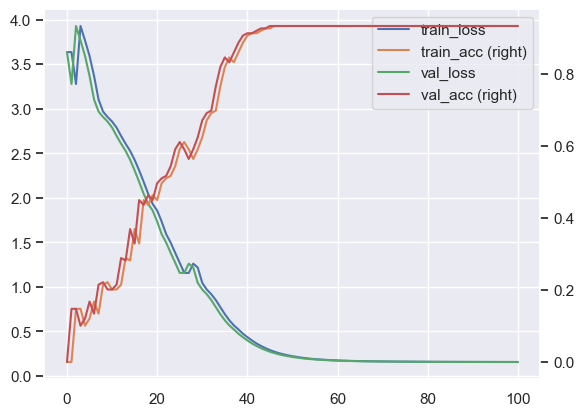

In [51]:
df = pd.DataFrame(history, columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'sample'])
df.plot(secondary_y=['train_acc', 'val_acc']);

Můžeme si všimnout, že úpěšnost na `overfit_lines` není 100 %, ale pouze cca 93 %. Podíváme se na predikce blíže, abychom zjistili, kde je problém. Zopakujeme nejprve ručně dopředný průchod sítí na `overfit_lines`, vytvoříme predikce indexů znaků `val_preds`, převedeme zpět do řetězců a porovnáme se správnými hodnotami.

In [52]:
# prepare data
val_ids = lines2indices(overfit_lines, chr2idx)  # (N, T)
val_inputs = val_ids[:, :-1].to(device=device)  # (N, T-1)
val_targets = val_ids[:, 1:].to(device=device)  # (N*(T-1),)

# forward pass
val_logits, val_hidden = model(val_inputs)  # (N, T-1, C), (1, N, H)

# deterministic predictions of next chars
val_preds = val_logits.argmax(dim=-1)

# compare as strings
pd.DataFrame(data=dict(predicted=indices2lines(val_preds.cpu()), true=indices2lines(val_targets.cpu())))

,predicted,true
0,pmluva,omluva
1,puc v zimbabwe,puc v zimbabwe
2,pudba jako lek,hudba jako lek
3,pmog na zlinsku,smog na zlinsku
4,pak na kocovinu,jak na kocovinu
5,pemrel b b king,zemrel b b king
6,poetzee v praze,coetzee v praze
7,puvni jarni den,prvni jarni den
8,piluji te modre,miluji te modre
9,pemrn je v cine,zeman je v cine


Jak vidíme, jako první znak za START/STOP tokenem síť vždy predikuje `'p'`, protože ten je spolu s `'z'` jedním ze dvou nejčastěji následujících. Tento druh chyby způsobí 8 chyb, tzn. vyskytne se u všech řádků nezačínajících `'p'`. Další chyba je na řádku 7, kdy sekvenci `'.p'` síť doplňuje na `'.pu'`, protože takto se to naučila z druhého nadpisu v trénovacích datech `overfit_lines` (nadpis `'puc v zimbabwe'`). Podobně pak 10. chyba vznikne na posledním řádku, kde vstup `.zem` síť doplní na `.zemr` dle nadpisu `'zemrel b b king'`, namísto správného `'zeman je v cine'`. Tyto nejednoznačnosti jsou nedílnou součástí dat a nelze je odstranit, a tak je stropem pro overfit accuracy ve skutečnosti 93.3 %, nikoliv 100 %.

## Optimalizace na plných datech

Po zkontrolování funkčnosti natrénujeme model na kompletních datech a konečně zkusíme vygenerovat nové nadpisy.

In [53]:
# reproducibility
random.seed(0)
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

# hyperparameters
trainset_ratio = 0.8
num_epochs = 20
batch_size = 50  # N
hidden_size = 512  # H
num_layers = 1  # L
rnn_type = torch.nn.GRU
mlp_config = ()
learning_rate = 1e-3
device = 'cuda'  # set to 'cpu' if CUDA not available

# overfit data
train_lines = lines[:int(trainset_ratio * len(lines))]
val_lines = lines[int(trainset_ratio * len(lines)):]
print(f"train:val split = {len(train_lines)}:{len(val_lines)}")

# model
model = CharRNN(len(chars), hidden_size=hidden_size, num_layers=num_layers, rnn_type=rnn_type, mlp_config=mlp_config)
model.to(device=device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loaders
train_loader = torch.utils.data.DataLoader(train_lines, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_lines, batch_size=batch_size, shuffle=False)

# sanity check: validate before training
train_loss, train_acc = validate(train_loader, model, criterion, batch_size=batch_size)
val_loss, val_acc = validate(val_loader, model, criterion, batch_size=batch_size)
samples = generate(model, [''], max_length=60)
history = [(train_loss, train_acc, val_loss, val_acc, samples[0])]
print(f"epoch=0, train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, val_loss={train_loss:.3f}, val_acc={train_acc:.3f}")

# training
for epoch in range(num_epochs):
    epoch_time = time.time()
    
    train_loss, train_acc = train(train_loader, model, criterion, optimizer, batch_size=batch_size)
    val_loss, val_acc = validate(val_loader, model, criterion, batch_size=batch_size)
    samples = generate(model, [''], max_length=60)
    history.append((train_loss, train_acc, val_loss, val_acc, samples[0]))
    
    print(f"epoch={epoch+1} ({time.time() - epoch_time:.1f}s), "
          f"train_loss={train_loss:.3f}, train_acc={train_acc:.3f}, "
          f"val_loss={val_loss:.3f}, val_acc={val_acc:.3f}, "
          f"sample='{samples[0]}'")

train:val split = 70427:17607
epoch=0, train_loss=3.634, train_acc=0.001, val_loss=3.634, val_acc=0.001
epoch=1 (17.3s), train_loss=2.187, train_acc=0.329, val_loss=1.828, val_acc=0.438, sample='zavahove pocitalu taz jmen odrozil zej v kalize tomi pred b'
epoch=2 (17.3s), train_loss=1.684, train_acc=0.480, val_loss=1.593, val_acc=0.507, sample='tri recitni centrum ctvrt srojte hrdinych ci'
epoch=3 (17.4s), train_loss=1.534, train_acc=0.523, val_loss=1.511, val_acc=0.531, sample='tykacka s maftedel konvojne haklaru je objevnich ji ztratit'
epoch=4 (17.4s), train_loss=1.461, train_acc=0.544, val_loss=1.467, val_acc=0.543, sample='nashedlici do polska nad ruskou pamottou penize ohermesy ja'
epoch=5 (17.5s), train_loss=1.415, train_acc=0.557, val_loss=1.441, val_acc=0.552, sample='dalla zranil stane lidske mexicky krokci zahraji kolem obav'
epoch=6 (17.5s), train_loss=1.382, train_acc=0.567, val_loss=1.423, val_acc=0.557, sample='stat zochvoli byt odije nalezeni trump'
epoch=7 (17.6s), tra

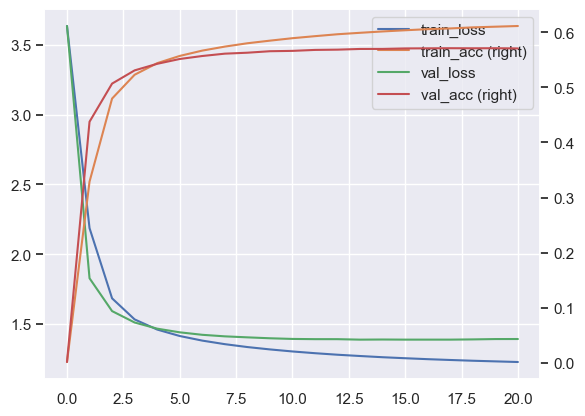

In [54]:
df = pd.DataFrame(history, columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'sample'])
df.plot(secondary_y=['train_acc', 'val_acc']);

In [55]:
# call this again to generate different text
generate(model, [''] * 10)

['ridici se vzacnou pozustalistu dalsi sestreleneho signala vrala',
 'recenze bij wrok a hasic predal vecerni silek rozpychy meli na ministerstvo',
 'ustavni soud odmitl stist vnitry plynovodci',
 'merkelova objevila alepadam elax andree',
 'slovak zuri na narodni tride polak vede',
 'pri prezidenta ve stojeni zacina boj e s ceskymi tratikem miri namorni galerii',
 'kralove knezech variji vydaneni zbrani do stredni estenek hravniho kurdami',
 'konzole mesice se vratil volkswagenem ceske drogy',
 'amozi si stale neolnachalo doslova dva miliony mesicu',
 'volbou se poprve pry melo pred silnymi jedineho a kamionu cast']